In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tables as ta
import numpy.ma as matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import time
from sklearn import decomposition as de
from scipy.linalg import pinv
import importlib as il
import scipy.optimize as opt
import sklearn.svm as svm
import scipy.io as sio
import copy

In [30]:
import src.deh as deh

In [142]:
il.reload(deh)

<module 'src.deh' from '/home/josephg/repos/hUH/src/deh.py'>

In [82]:
jasp = sio.loadmat("../../Documents/labelled_scenes/jasperRidge2_R198.mat")

In [69]:
#with version 0 and tightened constraints, with one loop, switched to spatial and increased min size
# looks like the lower threshold does help to split the water
deh2 = deh.DEH(no_negative_residuals=True)
deh2.splitting_size=1000
deh2.max_depth=2
deh2.max_iter=0
deh2.plot_size = (100,100)
deh2.plot_aspect = 1

In [70]:
ji = (jasp['Y'].astype(np.float32).T)

5437.0 0.0
M-initializes
original: 768491.4472695395
2


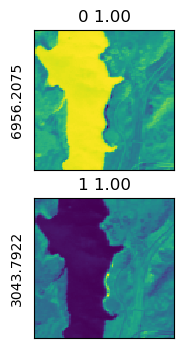

0.2832395136356354 [0.14161976]
2.0892319679260254 [1.044616]
1.4705891609191895 [0.7352946]
1.1960400342941284 [0.59802]
1.0237665176391602 [0.51188326]
0.9070602059364319 [0.4535301]
0.7974206805229187 [0.39871034]
0.7292735576629639 [0.36463678]
0.6798264384269714 [0.33991322]
0.6327357888221741 [0.3163679]
0.5900912880897522 [0.29504564]
0.5625674724578857 [0.28128374]
0.5296233892440796 [0.2648117]
0.5072546601295471 [0.25362733]
0.4857673943042755 [0.2428837]
0.46530279517173767 [0.2326514]
0.44679856300354004 [0.22339928]
0.43089067935943604 [0.21544534]
0.41685739159584045 [0.2084287]
0.4032405614852905 [0.20162028]
0.3905915319919586 [0.19529577]
0.37852704524993896 [0.18926352]
0.36817681789398193 [0.18408841]
0.35802263021469116 [0.17901132]
0.35026031732559204 [0.17513016]
0.3424113094806671 [0.17120565]
0.33417993783950806 [0.16708997]
0.32712888717651367 [0.16356444]
0.3202436566352844 [0.16012183]
0.3144190013408661 [0.1572095]
0.30748334527015686 [0.15374167]
0.30181220

0.10320720076560974 [0.0516036]
0.10309601575136185 [0.051548008]
0.10299208015203476 [0.05149604]
0.10287483781576157 [0.05143742]
0.1027788519859314 [0.051389426]
0.10268626362085342 [0.05134313]
0.10259789973497391 [0.05129895]
0.10249923914670944 [0.05124962]
0.10243002325296402 [0.05121501]
0.10234948247671127 [0.05117474]
0.10225405544042587 [0.051127028]
0.10214711725711823 [0.05107356]
0.10203894227743149 [0.05101947]
0.1019439846277237 [0.050971992]
0.10184735804796219 [0.05092368]
0.10174664109945297 [0.05087332]
0.1016346886754036 [0.050817344]
0.10154051333665848 [0.050770257]
0.10145056247711182 [0.05072528]
0.10137419402599335 [0.050687097]
0.10128144919872284 [0.050640725]
0.10119998455047607 [0.050599992]
0.10111355036497116 [0.050556775]
0.1010139212012291 [0.05050696]
0.10091134905815125 [0.050455675]
0.10081786662340164 [0.050408933]
0.10074640065431595 [0.0503732]
0.10064511001110077 [0.050322555]
0.10056183487176895 [0.050280917]
0.10048265010118484 [0.050241325]
0

0.09068109840154648 [0.04534055]
0.09065541625022888 [0.045327708]
0.09062395989894867 [0.04531198]
0.09060856699943542 [0.045304283]
0.09058786928653717 [0.045293935]
0.09056553989648819 [0.04528277]
0.09054367244243622 [0.045271836]
0.09052229672670364 [0.04526115]
0.0904979556798935 [0.045248978]
0.09047307074069977 [0.045236535]
0.09044500440359116 [0.045222502]
0.09042403846979141 [0.04521202]
0.09040086716413498 [0.045200434]
0.09037326276302338 [0.04518663]
0.09034718573093414 [0.045173593]
0.09032095223665237 [0.045160476]
0.09030374139547348 [0.04515187]
0.09028410166501999 [0.04514205]
0.09026515483856201 [0.045132577]
0.09024225175380707 [0.045121126]
0.09021653980016708 [0.04510827]
0.0901910737156868 [0.045095537]
0.09016958624124527 [0.045084793]
0.0901464968919754 [0.04507325]
0.09012798964977264 [0.045063995]
0.09011229127645493 [0.045056146]
0.09008803963661194 [0.04504402]
0.09006679058074951 [0.045033395]
0.09003982692956924 [0.045019913]
0.09001845866441727 [0.04500

0.08650650084018707 [0.04325325]
0.08649636805057526 [0.043248184]
0.0864851102232933 [0.043242555]
0.08647913485765457 [0.043239567]
0.08646958321332932 [0.04323479]
0.08646014332771301 [0.04323007]
0.08644317090511322 [0.043221585]
0.08643000572919846 [0.043215003]
0.08641743659973145 [0.04320872]
0.08640903979539871 [0.04320452]
0.08639507740736008 [0.04319754]
0.08638258278369904 [0.04319129]
0.08636964112520218 [0.04318482]
0.08635769784450531 [0.04317885]
0.08634268492460251 [0.043171342]
0.08632981777191162 [0.04316491]
0.08631837368011475 [0.043159187]
0.08630542457103729 [0.043152712]
0.08629391342401505 [0.043146957]
0.08628445118665695 [0.043142226]
0.08627618104219437 [0.04313809]
0.0862673968076706 [0.0431337]
0.08625709265470505 [0.043128546]
0.08624385297298431 [0.043121926]
0.08623561263084412 [0.043117806]
0.08622340857982635 [0.043111704]
0.08620861917734146 [0.04310431]
0.08619847148656845 [0.043099236]
0.08618733286857605 [0.043093666]
0.08617717027664185 [0.0430885

0.08434139937162399 [0.0421707]
0.08433575928211212 [0.04216788]
0.08432644605636597 [0.042163223]
0.08431973308324814 [0.042159867]
0.08431261032819748 [0.042156305]
0.08430498093366623 [0.04215249]
0.0842985287308693 [0.042149264]
0.08429327607154846 [0.042146638]
0.08428732305765152 [0.04214366]
0.08428065478801727 [0.042140327]
0.08427487313747406 [0.042137437]
0.08426825702190399 [0.04213413]
0.08426076173782349 [0.04213038]
0.0842556282877922 [0.042127814]
0.08424825966358185 [0.04212413]
0.0842427909374237 [0.042121395]
0.08423291891813278 [0.04211646]
0.08422583341598511 [0.042112917]
0.08421861380338669 [0.042109307]
0.08421330153942108 [0.04210665]
0.0842084139585495 [0.042104207]
0.08420048654079437 [0.042100243]
0.0841953307390213 [0.042097665]
0.08418804407119751 [0.042094022]
0.08418026566505432 [0.042090133]
0.0841742604970932 [0.04208713]
0.08416587859392166 [0.04208294]
0.08415964990854263 [0.042079825]
0.08415421098470688 [0.042077105]
0.08414790034294128 [0.04207395]

0.0829896554350853 [0.041494828]
0.08298534154891968 [0.04149267]
0.08298145234584808 [0.041490726]
0.0829770416021347 [0.04148852]
0.0829722136259079 [0.041486107]
0.08296707272529602 [0.041483536]
0.0829625055193901 [0.041481253]
0.08295904099941254 [0.04147952]
0.0829567089676857 [0.041478354]
0.08295272290706635 [0.04147636]
0.08294731378555298 [0.041473657]
0.08294228464365005 [0.041471142]
0.08293819427490234 [0.041469097]
0.08293343335390091 [0.041466717]
0.0829295739531517 [0.041464787]
0.08292493969202042 [0.04146247]
0.08292173594236374 [0.041460868]
0.08291851729154587 [0.04145926]
0.08291298151016235 [0.04145649]
0.08290871232748032 [0.041454356]
0.08290450274944305 [0.04145225]
0.08289960026741028 [0.0414498]
0.08289548754692078 [0.041447744]
0.08289061486721039 [0.041445307]
0.08288607746362686 [0.04144304]
0.08288261294364929 [0.041441306]
0.08287926018238068 [0.04143963]
0.08287602663040161 [0.041438013]
0.08287224173545837 [0.04143612]
0.08286712318658829 [0.04143356]


0.08205821365118027 [0.041029107]
0.08205419778823853 [0.0410271]
0.08205077052116394 [0.041025385]
0.08204908668994904 [0.041024543]
0.08204638957977295 [0.041023195]
0.08204277604818344 [0.041021388]
0.08204039186239243 [0.041020196]
0.08203763514757156 [0.041018818]
0.08203595131635666 [0.041017976]
0.0820317417383194 [0.04101587]
0.08202794939279556 [0.041013975]
0.08202386647462845 [0.041011933]
0.08202080428600311 [0.041010402]
0.08201701194047928 [0.041008506]
0.08201254904270172 [0.041006275]
0.08200953900814056 [0.04100477]
0.08200786262750626 [0.04100393]
0.08200517296791077 [0.041002586]
0.08200222998857498 [0.041001115]
0.08199933916330338 [0.04099967]
0.08199675381183624 [0.040998377]
0.08199572563171387 [0.040997863]
0.08199400454759598 [0.040997002]
0.08199075609445572 [0.040995378]
0.08198820799589157 [0.040994104]
0.08198483288288116 [0.040992416]
0.08198168873786926 [0.040990844]
0.08197770267724991 [0.04098885]
0.08197417855262756 [0.04098709]
0.08196944743394852 [0.

0.08139336854219437 [0.040696684]
0.0813903957605362 [0.040695198]
0.08138836920261383 [0.040694185]
0.08138655126094818 [0.040693276]
0.0813845619559288 [0.04069228]
0.08138225227594376 [0.040691126]
0.08138038218021393 [0.04069019]
0.08137771487236023 [0.040688857]
0.0813751295208931 [0.040687565]
0.08137250691652298 [0.040686253]
0.0813700407743454 [0.04068502]
0.08136799931526184 [0.040684]
0.08136463165283203 [0.040682316]
0.08136202394962311 [0.040681012]
0.08135965466499329 [0.040679827]
0.0813579335808754 [0.040678967]
0.08135586231946945 [0.04067793]
0.0813538208603859 [0.04067691]
0.08135151118040085 [0.040675756]
0.08134955912828445 [0.04067478]
0.08134743571281433 [0.040673718]
0.08134434372186661 [0.04067217]
0.08134154975414276 [0.040670775]
0.08133923262357712 [0.040669616]
0.08133736252784729 [0.04066868]
0.08133584260940552 [0.04066792]
0.08133295923471451 [0.04066648]
0.08133048564195633 [0.040665243]
0.0813283696770668 [0.040664185]
0.08132614940404892 [0.040663075]


0.209738127887249 [0.040633913, 0.032117575]
0.20949167758226395 [0.040633913, 0.032055963]
0.20926911383867264 [0.040633913, 0.032000322]
0.2090621516108513 [0.040633913, 0.03194858]
0.20883267372846603 [0.040633913, 0.031891212]
0.2085805907845497 [0.040633913, 0.03182819]
0.20834118872880936 [0.040633913, 0.03176834]
0.20812923461198807 [0.040633913, 0.031715352]
0.20791081339120865 [0.040633913, 0.031660747]
0.20769710093736649 [0.040633913, 0.03160732]
0.2074851617217064 [0.040633913, 0.031554334]
0.20727438479661942 [0.040633913, 0.03150164]
0.2070992812514305 [0.040633913, 0.031457864]
0.2068914696574211 [0.040633913, 0.03140591]
0.20666321367025375 [0.040633913, 0.031348847]
0.20643826574087143 [0.040633913, 0.03129261]
0.20620449632406235 [0.040633913, 0.031234168]
0.20598259568214417 [0.040633913, 0.031178692]
0.20576050132513046 [0.040633913, 0.031123169]
0.20552778989076614 [0.040633913, 0.03106499]
0.20532533526420593 [0.040633913, 0.031014377]
0.20512515306472778 [0.04063

0.18275205045938492 [0.040633913, 0.025371056]
0.18265169113874435 [0.040633913, 0.025345966]
0.1825718730688095 [0.040633913, 0.025326012]
0.1824614182114601 [0.040633913, 0.025298398]
0.18238353729248047 [0.040633913, 0.025278928]
0.18230409920215607 [0.040633913, 0.025259068]
0.18221457302570343 [0.040633913, 0.025236687]
0.18213333189487457 [0.040633913, 0.025216376]
0.1820530667901039 [0.040633913, 0.02519631]
0.18196651339530945 [0.040633913, 0.025174672]
0.18189577013254166 [0.040633913, 0.025156986]
0.18180397897958755 [0.040633913, 0.025134038]
0.18170736730098724 [0.040633913, 0.025109885]
0.1816386803984642 [0.040633913, 0.025092714]
0.18157031387090683 [0.040633913, 0.025075622]
0.1814955770969391 [0.040633913, 0.025056938]
0.1814066618680954 [0.040633913, 0.025034709]
0.1813233494758606 [0.040633913, 0.02501388]
0.1812358796596527 [0.040633913, 0.024992013]
0.18116023391485214 [0.040633913, 0.024973102]
0.1810833141207695 [0.040633913, 0.024953872]
0.18100035190582275 [0.0

0.171674482524395 [0.040633913, 0.022601664]
0.17162366211414337 [0.040633913, 0.022588959]
0.17157337069511414 [0.040633913, 0.022576386]
0.1715279296040535 [0.040633913, 0.022565026]
0.17148256301879883 [0.040633913, 0.022553684]
0.17144516855478287 [0.040633913, 0.022544336]
0.1713949590921402 [0.040633913, 0.022531783]
0.171344555914402 [0.040633913, 0.022519182]
0.1712995171546936 [0.040633913, 0.022507923]
0.17125992476940155 [0.040633913, 0.022498025]
0.17120563238859177 [0.040633913, 0.022484452]
0.17116472870111465 [0.040633913, 0.022474226]
0.171121284365654 [0.040633913, 0.022463365]
0.17108236998319626 [0.040633913, 0.022453636]
0.1710415631532669 [0.040633913, 0.022443434]
0.17099371552467346 [0.040633913, 0.022431472]
0.17094827443361282 [0.040633913, 0.022420112]
0.17090550810098648 [0.040633913, 0.02240942]
0.17086279392242432 [0.040633913, 0.022398742]
0.17082374542951584 [0.040633913, 0.02238898]
0.17077703773975372 [0.040633913, 0.022377303]
0.17073548585176468 [0.04

0.16560722142457962 [0.040633913, 0.021084849]
0.1655828356742859 [0.040633913, 0.021078752]
0.16556177288293839 [0.040633913, 0.021073487]
0.16554681956768036 [0.040633913, 0.021069748]
0.1655140370130539 [0.040633913, 0.021061553]
0.1654784306883812 [0.040633913, 0.021052651]
0.16545894742012024 [0.040633913, 0.02104778]
0.16543367505073547 [0.040633913, 0.021041462]
0.16540751606225967 [0.040633913, 0.021034922]
0.1653783619403839 [0.040633913, 0.021027634]
0.16535568982362747 [0.040633913, 0.021021966]
0.16532891988754272 [0.040633913, 0.021015273]
0.1653025522828102 [0.040633913, 0.021008682]
0.16527625918388367 [0.040633913, 0.021002108]
0.16525820642709732 [0.040633913, 0.020997595]
0.1652311608195305 [0.040633913, 0.020990834]
0.16520526260137558 [0.040633913, 0.02098436]
0.16518259048461914 [0.040633913, 0.020978691]
0.165159210562706 [0.040633913, 0.020972846]
0.16513828188180923 [0.040633913, 0.020967614]
0.16511858254671097 [0.040633913, 0.02096269]
0.16509300470352173 [0.0

0.161786749958992 [0.040633913, 0.02012973]
0.1617693230509758 [0.040633913, 0.020125374]
0.16175488382577896 [0.040633913, 0.020121764]
0.16173404455184937 [0.040633913, 0.020116555]
0.16171658784151077 [0.040633913, 0.02011219]
0.16169998794794083 [0.040633913, 0.02010804]
0.16167956590652466 [0.040633913, 0.020102935]
0.16166000068187714 [0.040633913, 0.020098044]
0.16164221614599228 [0.040633913, 0.020093597]
0.16162613779306412 [0.040633913, 0.020089578]
0.16160739213228226 [0.040633913, 0.020084891]
0.16159158200025558 [0.040633913, 0.020080939]
0.16157224029302597 [0.040633913, 0.020076104]
0.16155938804149628 [0.040633913, 0.02007289]
0.16154414415359497 [0.040633913, 0.02006908]
0.16152772307395935 [0.040633913, 0.020064974]
0.16151022166013718 [0.040633913, 0.020060599]
0.1614934653043747 [0.040633913, 0.02005641]
0.1614755541086197 [0.040633913, 0.020051932]
0.16145826876163483 [0.040633913, 0.02004761]
0.16144011169672012 [0.040633913, 0.020043071]
0.16141988337039948 [0.04

0.15902485698461533 [0.040633913, 0.019439258]
0.15900719165802002 [0.040633913, 0.019434841]
0.15899494290351868 [0.040633913, 0.01943178]
0.15898317843675613 [0.040633913, 0.019428838]
0.15896927565336227 [0.040633913, 0.019425362]
0.15895606577396393 [0.040633913, 0.01942206]
0.15894226729869843 [0.040633913, 0.01941861]
0.15892793983221054 [0.040633913, 0.019415028]
0.15891776233911514 [0.040633913, 0.019412484]
0.15890391916036606 [0.040633913, 0.019409023]
0.1588900163769722 [0.040633913, 0.019405548]
0.15887770801782608 [0.040633913, 0.01940247]
0.1588623970746994 [0.040633913, 0.019398643]
0.15885081887245178 [0.040633913, 0.019395748]
0.1588396653532982 [0.040633913, 0.01939296]
0.15882938355207443 [0.040633913, 0.01939039]
0.1588154286146164 [0.040633913, 0.0193869]
0.15880842506885529 [0.040633913, 0.01938515]
0.15879959613084793 [0.040633913, 0.019382942]
0.1587827205657959 [0.040633913, 0.019378724]
0.15877244621515274 [0.040633913, 0.019376155]
0.15876098722219467 [0.0406

0.15694446116685867 [0.040633913, 0.018919159]
0.15693750232458115 [0.040633913, 0.018917419]
0.1569254845380783 [0.040633913, 0.018914415]
0.15691472589969635 [0.040633913, 0.018911725]
0.15690243989229202 [0.040633913, 0.018908653]
0.15689265727996826 [0.040633913, 0.018906208]
0.1568831503391266 [0.040633913, 0.018903831]
0.15687204152345657 [0.040633913, 0.018901054]
0.15686357021331787 [0.040633913, 0.018898936]
0.15685449540615082 [0.040633913, 0.018896667]
0.1568482741713524 [0.040633913, 0.018895112]
0.1568378061056137 [0.040633913, 0.018892495]
0.1568286344408989 [0.040633913, 0.018890202]
0.15682198107242584 [0.040633913, 0.018888539]
0.15680775791406631 [0.040633913, 0.018884983]
0.15679489821195602 [0.040633913, 0.018881768]
0.15678365528583527 [0.040633913, 0.018878957]
0.1567719578742981 [0.040633913, 0.018876033]
0.1567608043551445 [0.040633913, 0.018873245]
0.15675143897533417 [0.040633913, 0.018870903]
0.15674320608377457 [0.040633913, 0.018868845]
0.1567341759800911 [

0.15531354397535324 [0.040633913, 0.01851143]
0.15530351549386978 [0.040633913, 0.018508922]
0.15529748797416687 [0.040633913, 0.018507415]
0.15528831630945206 [0.040633913, 0.018505123]
0.15528088808059692 [0.040633913, 0.018503265]
0.15527401864528656 [0.040633913, 0.018501548]
0.1552644819021225 [0.040633913, 0.018499164]
0.1552579402923584 [0.040633913, 0.018497529]
0.15525076538324356 [0.040633913, 0.018495735]
0.1552460640668869 [0.040633913, 0.01849456]
0.1552334576845169 [0.040633913, 0.018491408]
0.15522357821464539 [0.040633913, 0.018488938]
0.15521536022424698 [0.040633913, 0.018486883]
0.15520907938480377 [0.040633913, 0.018485313]
0.15520218014717102 [0.040633913, 0.018483588]
0.15519379079341888 [0.040633913, 0.018481491]
0.15518581122159958 [0.040633913, 0.018479496]
0.15517819672822952 [0.040633913, 0.018477593]
0.1551680788397789 [0.040633913, 0.018475063]
0.15516354888677597 [0.040633913, 0.01847393]
0.1551511511206627 [0.040633913, 0.018470831]
0.15514060109853745 [0

0.1539866402745247 [0.040633913, 0.018179704]
0.15397821366786957 [0.040633913, 0.018177597]
0.15397197008132935 [0.040633913, 0.018176036]
0.15396644175052643 [0.040633913, 0.018174654]
0.15395895391702652 [0.040633913, 0.018172782]
0.15395383536815643 [0.040633913, 0.018171502]
0.15394610911607742 [0.040633913, 0.01816957]
0.15393681824207306 [0.040633913, 0.018167248]
0.1539296805858612 [0.040633913, 0.018165464]
0.15392327308654785 [0.040633913, 0.018163862]
0.15391447395086288 [0.040633913, 0.018161662]
0.1539066955447197 [0.040633913, 0.018159717]
0.1539028212428093 [0.040633913, 0.018158749]
0.15389693528413773 [0.040633913, 0.018157277]
0.1538889929652214 [0.040633913, 0.018155292]
0.15388131141662598 [0.040633913, 0.018153371]
0.1538749858736992 [0.040633913, 0.01815179]
0.15386871993541718 [0.040633913, 0.018150223]
0.15386324375867844 [0.040633913, 0.018148854]
0.15385735034942627 [0.040633913, 0.018147381]
0.15384935587644577 [0.040633913, 0.018145382]
0.15384352207183838 [

0.15287361294031143 [0.040633913, 0.017901447]
0.15287134051322937 [0.040633913, 0.017900879]
0.1528671607375145 [0.040633913, 0.017899834]
0.15286163240671158 [0.040633913, 0.017898452]
0.15285688638687134 [0.040633913, 0.017897265]
0.1528511419892311 [0.040633913, 0.017895829]
0.15284480899572372 [0.040633913, 0.017894246]
0.15283821523189545 [0.040633913, 0.017892597]
0.15283190459012985 [0.040633913, 0.01789102]
0.15282724052667618 [0.040633913, 0.017889854]
0.15282240509986877 [0.040633913, 0.017888645]
0.1528148278594017 [0.040633913, 0.01788675]
0.15281088650226593 [0.040633913, 0.017885765]
0.15280313789844513 [0.040633913, 0.017883828]
0.15279652923345566 [0.040633913, 0.017882176]
0.1527920737862587 [0.040633913, 0.017881062]
0.15278593450784683 [0.040633913, 0.017879527]
0.1527804285287857 [0.040633913, 0.01787815]
0.15277451276779175 [0.040633913, 0.017876672]
0.15276776254177094 [0.040633913, 0.017874984]
0.15276288986206055 [0.040633913, 0.017873766]
0.15275754034519196 [

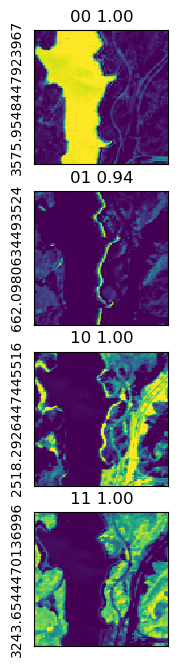

In [71]:
samppts = np.random.choice(10000,1000)
o_rec = [0]
deh2.grow_network_open(ji, beta=0.5, tol=1e-5, obj_record=o_rec, sampling_points=samppts)

4


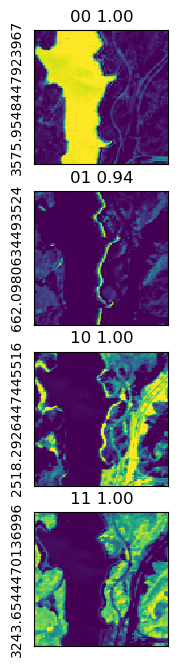

In [72]:
deh2.display_level(2)

In [76]:
o_rec.pop(0)

0

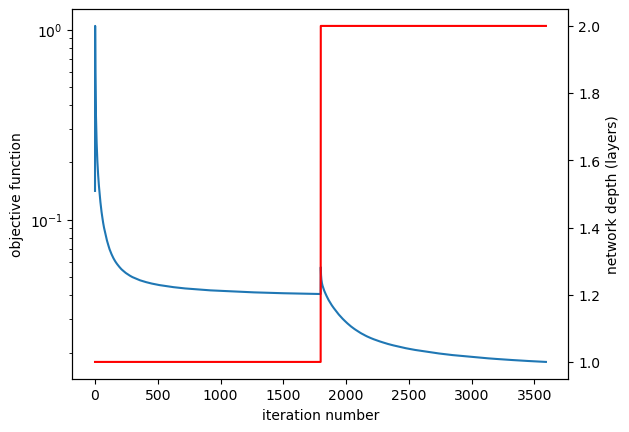

In [77]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.semilogy(np.array(o_rec)[:,0])
ax.set_xlabel("iteration number")
ax.set_ylabel("objective function")
ax1.set_ylabel("network depth (layers)")
ax1.plot(np.array(o_rec)[:,2], color='red')

In [210]:
#with version 0 and tightened constraints, with one loop, switched to spatial and increased min size
# looks like the lower threshold does help to split the water
deh3 = deh.DEH(no_negative_residuals=True)
deh3.splitting_size=1000
deh3.max_depth=2
deh3.max_iter=0
deh3.plot_size = (100,100)
deh3.plot_aspect = 1

5437.0 0.0
M-initializes
original: 768491.4472695395
2


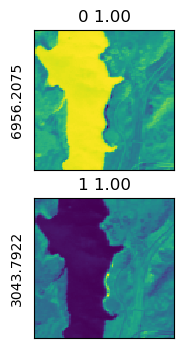

0.28893157839775085 [0.14446579]
2.0205307006835938 [1.0102654]
1.4867429733276367 [0.7433715]
1.1699116230010986 [0.5849558]
0.9748023152351379 [0.48740116]
0.8570194840431213 [0.42850974]
0.7695608735084534 [0.38478044]
0.7069413065910339 [0.35347065]
0.6508527994155884 [0.3254264]
0.6152063012123108 [0.30760315]
0.5762184858322144 [0.28810924]
0.5426661372184753 [0.27133307]
0.5187528133392334 [0.2593764]
0.49825817346572876 [0.24912909]
0.47725024819374084 [0.23862512]
0.45571959018707275 [0.2278598]
0.43547722697257996 [0.21773861]
0.41912856698036194 [0.20956428]
0.4057639539241791 [0.20288198]
0.393621027469635 [0.19681051]
0.38060125708580017 [0.19030063]
0.37116119265556335 [0.1855806]
0.36181482672691345 [0.18090741]
0.35292837023735046 [0.17646419]
0.344142347574234 [0.17207117]
0.33545348048210144 [0.16772674]
0.3278501033782959 [0.16392505]
0.3215557336807251 [0.16077787]
0.31453630328178406 [0.15726815]
0.3086107075214386 [0.15430535]
0.30202531814575195 [0.15101266]
0.29

0.1016070768237114 [0.05080354]
0.10151448100805283 [0.05075724]
0.10141167044639587 [0.050705835]
0.1013178750872612 [0.050658938]
0.10122483223676682 [0.050612416]
0.10111863166093826 [0.050559316]
0.10102769732475281 [0.05051385]
0.10093614459037781 [0.050468072]
0.10085014253854752 [0.05042507]
0.10076971352100372 [0.050384857]
0.10069014132022858 [0.05034507]
0.10058757662773132 [0.05029379]
0.1004929393529892 [0.05024647]
0.10041128098964691 [0.05020564]
0.10033734142780304 [0.05016867]
0.10025317221879959 [0.050126586]
0.10018086433410645 [0.050090432]
0.10011859238147736 [0.050059296]
0.10001524537801743 [0.050007623]
0.09994262456893921 [0.049971312]
0.0998469814658165 [0.04992349]
0.09976805746555328 [0.04988403]
0.09968361258506775 [0.049841806]
0.09960617125034332 [0.049803086]
0.09951033443212509 [0.049755167]
0.09944110363721848 [0.04972055]
0.09937231242656708 [0.049686156]
0.09928474575281143 [0.049642373]
0.0992039293050766 [0.049601965]
0.0991397425532341 [0.04956987]

0.09018797427415848 [0.045093987]
0.09016053378582001 [0.045080267]
0.09014188498258591 [0.045070942]
0.09012573212385178 [0.045062866]
0.09010278433561325 [0.045051392]
0.09007958322763443 [0.04503979]
0.09006091207265854 [0.045030456]
0.0900433212518692 [0.04502166]
0.09002546966075897 [0.045012735]
0.08999563753604889 [0.04499782]
0.0899750366806984 [0.04498752]
0.08995061367750168 [0.044975307]
0.08992788940668106 [0.044963945]
0.08989962935447693 [0.044949815]
0.08987706899642944 [0.044938534]
0.08985555917024612 [0.04492778]
0.08983606100082397 [0.04491803]
0.08981598913669586 [0.044907995]
0.08978767693042755 [0.04489384]
0.08977080136537552 [0.0448854]
0.08975326269865036 [0.04487663]
0.08973366022109985 [0.04486683]
0.08970891684293747 [0.04485446]
0.08968745172023773 [0.044843726]
0.08967110514640808 [0.044835553]
0.08964979648590088 [0.0448249]
0.0896330401301384 [0.04481652]
0.08961085230112076 [0.044805426]
0.0895947515964508 [0.044797376]
0.08957085013389587 [0.044785425]

0.0865812674164772 [0.043290634]
0.08656848222017288 [0.04328424]
0.0865577906370163 [0.043278895]
0.08655089139938354 [0.043275446]
0.08654259890317917 [0.0432713]
0.08653289824724197 [0.04326645]
0.08652745187282562 [0.043263726]
0.08651787042617798 [0.043258935]
0.08650744706392288 [0.043253724]
0.08649594336748123 [0.04324797]
0.08648773282766342 [0.043243866]
0.08647599816322327 [0.043238]
0.08646276593208313 [0.043231383]
0.08645337074995041 [0.043226685]
0.0864439532160759 [0.043221977]
0.08643496036529541 [0.04321748]
0.08642563223838806 [0.043212816]
0.08641611784696579 [0.04320806]
0.08640197664499283 [0.04320099]
0.08639207482337952 [0.043196037]
0.08638405054807663 [0.043192025]
0.08637544512748718 [0.043187723]
0.08636500686407089 [0.043182503]
0.08635582029819489 [0.04317791]
0.08634526282548904 [0.04317263]
0.08633683621883392 [0.043168418]
0.08632709830999374 [0.04316355]
0.08631901443004608 [0.043159507]
0.08631140738725662 [0.043155704]
0.08630158007144928 [0.04315079

0.08472854644060135 [0.042364273]
0.08472322672605515 [0.042361613]
0.08471755683422089 [0.04235878]
0.08471096307039261 [0.04235548]
0.08470532298088074 [0.04235266]
0.08469955623149872 [0.042349778]
0.08469244092702866 [0.04234622]
0.08468664437532425 [0.042343322]
0.08468153327703476 [0.042340767]
0.08467710763216019 [0.042338554]
0.08467213809490204 [0.04233607]
0.08466678857803345 [0.042333394]
0.08466058224439621 [0.04233029]
0.08465597778558731 [0.04232799]
0.08465120196342468 [0.0423256]
0.08464641124010086 [0.042323206]
0.08464068919420242 [0.042320345]
0.08463507145643234 [0.042317536]
0.0846300944685936 [0.042315047]
0.08462361991405487 [0.04231181]
0.08461917191743851 [0.042309586]
0.0846124142408371 [0.042306207]
0.08460722118616104 [0.04230361]
0.08460281044244766 [0.042301405]
0.08459588885307312 [0.042297944]
0.08459042757749557 [0.042295214]
0.08458561450242996 [0.042292807]
0.08458157628774643 [0.04229079]
0.08457525819540024 [0.04228763]
0.08457055687904358 [0.042285

0.08364196121692657 [0.04182098]
0.08363761007785797 [0.041818805]
0.08363351225852966 [0.041816756]
0.08362897485494614 [0.041814487]
0.08362562209367752 [0.04181281]
0.08362273871898651 [0.04181137]
0.08361969143152237 [0.041809846]
0.0836152657866478 [0.041807633]
0.0836106538772583 [0.041805327]
0.08360788226127625 [0.04180394]
0.08360448479652405 [0.041802242]
0.08360011130571365 [0.041800056]
0.08359801769256592 [0.04179901]
0.0835941880941391 [0.041797094]
0.08359077572822571 [0.041795388]
0.08358712494373322 [0.041793562]
0.08358226716518402 [0.041791134]
0.08357802033424377 [0.04178901]
0.08357485383749008 [0.041787427]
0.0835719183087349 [0.04178596]
0.0835682824254036 [0.04178414]
0.08356484770774841 [0.041782424]
0.08356068283319473 [0.04178034]
0.08355647325515747 [0.041778237]
0.0835513323545456 [0.041775666]
0.08354683220386505 [0.041773416]
0.08354482799768448 [0.041772414]
0.08354200422763824 [0.041771002]
0.08353857696056366 [0.04176929]
0.08353500068187714 [0.0417675

0.08289983868598938 [0.04144992]
0.08289741724729538 [0.04144871]
0.08289538323879242 [0.04144769]
0.0828932374715805 [0.04144662]
0.0828903317451477 [0.041445166]
0.08288746327161789 [0.04144373]
0.08288466185331345 [0.04144233]
0.08288209140300751 [0.041441046]
0.08287853747606277 [0.04143927]
0.08287587761878967 [0.04143794]
0.08287343382835388 [0.041436717]
0.08287105709314346 [0.04143553]
0.08286865055561066 [0.041434325]
0.08286596089601517 [0.04143298]
0.08286380767822266 [0.041431904]
0.08286077529191971 [0.041430388]
0.08285899460315704 [0.041429497]
0.08285634219646454 [0.04142817]
0.08285418897867203 [0.041427094]
0.0828518494963646 [0.041425925]
0.08284921944141388 [0.04142461]
0.08284656703472137 [0.041423284]
0.08284520357847214 [0.0414226]
0.08284352719783783 [0.041421764]
0.08284086734056473 [0.041420434]
0.08283868432044983 [0.041419342]
0.0828365609049797 [0.04141828]
0.08283409476280212 [0.041417047]
0.08283185213804245 [0.041415926]
0.08282861113548279 [0.041414306]

0.08237254619598389 [0.041186273]
0.08237121254205704 [0.041185606]
0.08236842602491379 [0.041184213]
0.08236677199602127 [0.041183386]
0.0823652595281601 [0.04118263]
0.08236339688301086 [0.0411817]
0.08236157894134521 [0.04118079]
0.08236023038625717 [0.041180115]
0.08235803991556168 [0.04117902]
0.0823565348982811 [0.041178267]
0.08235488831996918 [0.041177444]
0.08235345780849457 [0.04117673]
0.08235124498605728 [0.041175622]
0.08234933763742447 [0.04117467]
0.0823477953672409 [0.041173898]
0.08234590291976929 [0.04117295]
0.08234425634145737 [0.04117213]
0.08234258741140366 [0.041171294]
0.08234146237373352 [0.04117073]
0.08233901858329773 [0.04116951]
0.08233629167079926 [0.041168146]
0.08233387768268585 [0.04116694]
0.08233246207237244 [0.04116623]
0.08233009278774261 [0.041165046]
0.08232780545949936 [0.041163903]
0.08232667297124863 [0.041163336]
0.08232397586107254 [0.041161988]
0.08232160657644272 [0.041160803]
0.08232017606496811 [0.041160088]
0.08231832087039948 [0.0411591

0.08197584003210068 [0.04098792]
0.08197472244501114 [0.04098736]
0.08197325468063354 [0.040986627]
0.0819714367389679 [0.04098572]
0.08197015523910522 [0.040985078]
0.08196836709976196 [0.040984184]
0.08196685463190079 [0.040983427]
0.08196543902158737 [0.04098272]
0.081964872777462 [0.040982436]
0.08196353912353516 [0.04098177]
0.08196207135915756 [0.040981036]
0.08196092396974564 [0.040980462]
0.08195951581001282 [0.040979758]
0.0819578617811203 [0.04097893]
0.08195669949054718 [0.04097835]
0.08195611089468002 [0.040978055]
0.08195483684539795 [0.04097742]
0.08195338398218155 [0.040976692]
0.08195173740386963 [0.04097587]
0.08195053040981293 [0.040975265]
0.0819488912820816 [0.040974446]
0.0819479376077652 [0.04097397]
0.08194681257009506 [0.040973406]
0.08194588124752045 [0.04097294]
0.08194403350353241 [0.040972017]
0.0819428414106369 [0.04097142]
0.08194149285554886 [0.040970746]
0.08194032311439514 [0.04097016]
0.08193924278020859 [0.04096962]
0.081937775015831 [0.040968888]
0.0

0.08166901767253876 [0.04083451]
0.08166736364364624 [0.04083368]
0.08166567236185074 [0.040832836]
0.08166447281837463 [0.040832236]
0.08166349679231644 [0.04083175]
0.08166278898715973 [0.040831394]
0.08166173100471497 [0.040830866]
0.08166052401065826 [0.040830262]
0.08165919780731201 [0.0408296]
0.08165794610977173 [0.040828973]
0.08165641874074936 [0.04082821]
0.08165518194437027 [0.04082759]
0.08165410906076431 [0.040827055]
0.08165270835161209 [0.040826354]
0.0816517323255539 [0.040825866]
0.08165036886930466 [0.040825184]
0.08164988458156586 [0.040824942]
0.08164846152067184 [0.04082423]
0.08164723217487335 [0.040823616]
0.08164599537849426 [0.040822998]
0.08164477348327637 [0.040822387]
0.08164390921592712 [0.040821955]
0.08164243400096893 [0.040821217]
0.08164100348949432 [0.0408205]
0.08164007216691971 [0.040820036]
0.08163899183273315 [0.040819496]
0.08163801580667496 [0.040819008]
0.0816364586353302 [0.04081823]
0.08163537830114365 [0.04081769]
0.08163455873727798 [0.04081

0.24301296472549438 [0.04073722, 0.04038463]
0.24298161268234253 [0.04073722, 0.040376794]
0.24295082688331604 [0.04073722, 0.040369097]
0.24292172491550446 [0.04073722, 0.04036182]
0.24289140105247498 [0.04073722, 0.04035424]
0.24286004900932312 [0.04073722, 0.040346403]
0.24282880127429962 [0.04073722, 0.04033859]
0.24279679358005524 [0.04073722, 0.04033059]
0.24276737868785858 [0.04073722, 0.040323235]
0.24273668229579926 [0.04073722, 0.04031556]
0.2427024096250534 [0.04073722, 0.040306993]
0.24267055094242096 [0.04073722, 0.04029903]
0.24263975024223328 [0.04073722, 0.040291328]
0.24260425567626953 [0.04073722, 0.040282454]
0.2425691932439804 [0.04073722, 0.04027369]
0.24253962934017181 [0.04073722, 0.040266298]
0.24251031875610352 [0.04073722, 0.04025897]
0.2424798160791397 [0.04073722, 0.040251344]
0.2424473911523819 [0.04073722, 0.04024324]
0.24242003262043 [0.04073722, 0.0402364]
0.2423890233039856 [0.04073722, 0.040228646]
0.24235567450523376 [0.04073722, 0.04022031]
0.2423284

0.2376026213169098 [0.04073722, 0.039032046]
0.23757152259349823 [0.04073722, 0.03902427]
0.23754826188087463 [0.04073722, 0.039018456]
0.2375175952911377 [0.04073722, 0.03901079]
0.23748533427715302 [0.04073722, 0.039002724]
0.23745787143707275 [0.04073722, 0.03899586]
0.23743091523647308 [0.04073722, 0.03898912]
0.23740479350090027 [0.04073722, 0.03898259]
0.23737496137619019 [0.04073722, 0.03897513]
0.2373463213443756 [0.04073722, 0.03896797]
0.23731696605682373 [0.04073722, 0.038960632]
0.23728688061237335 [0.04073722, 0.03895311]
0.23726357519626617 [0.04073722, 0.038947284]
0.23723053932189941 [0.04073722, 0.038939025]
0.23720185458660126 [0.04073722, 0.038931854]
0.23717118799686432 [0.04073722, 0.038924187]
0.23714236915111542 [0.04073722, 0.038916983]
0.23711612820625305 [0.04073722, 0.038910422]
0.23708975315093994 [0.04073722, 0.03890383]
0.23706258833408356 [0.04073722, 0.038897038]
0.23703724145889282 [0.04073722, 0.0388907]
0.23700834810733795 [0.04073722, 0.038883477]
0.

0.23188404738903046 [0.04073722, 0.037602402]
0.23185332119464874 [0.04073722, 0.03759472]
0.23181867599487305 [0.04073722, 0.03758606]
0.23178265988826752 [0.04073722, 0.037577055]
0.23174487054347992 [0.04073722, 0.037567608]
0.2317138910293579 [0.04073722, 0.037559863]
0.23168066143989563 [0.04073722, 0.037551556]
0.2316427081823349 [0.04073722, 0.037542067]
0.23160988092422485 [0.04073722, 0.03753386]
0.23157279193401337 [0.04073722, 0.03752459]
0.23153914511203766 [0.04073722, 0.037516177]
0.2315049022436142 [0.04073722, 0.037507616]
0.23147174715995789 [0.04073722, 0.037499327]
0.23143671452999115 [0.04073722, 0.03749057]
0.23139889538288116 [0.04073722, 0.037481114]
0.2313671112060547 [0.04073722, 0.03747317]
0.23133228719234467 [0.04073722, 0.037464462]
0.2312982976436615 [0.04073722, 0.037455965]
0.23126450181007385 [0.04073722, 0.037447516]
0.23122571408748627 [0.04073722, 0.03743782]
0.23118863999843597 [0.04073722, 0.03742855]
0.231155663728714 [0.04073722, 0.037420306]
0.2

0.22421900928020477 [0.04073722, 0.035686143]
0.22417248785495758 [0.04073722, 0.035674512]
0.2241261601448059 [0.04073722, 0.03566293]
0.22408254444599152 [0.04073722, 0.035652027]
0.22402918338775635 [0.04073722, 0.035638686]
0.22398066520690918 [0.04073722, 0.035626557]
0.2239362895488739 [0.04073722, 0.035615463]
0.22389011085033417 [0.04073722, 0.035603918]
0.22384168207645416 [0.04073722, 0.03559181]
0.22379478812217712 [0.04073722, 0.035580087]
0.22374515235424042 [0.04073722, 0.03556768]
0.22370228171348572 [0.04073722, 0.03555696]
0.22365351021289825 [0.04073722, 0.035544768]
0.22360405325889587 [0.04073722, 0.035532404]
0.22354881465435028 [0.04073722, 0.035518594]
0.22350989282131195 [0.04073722, 0.035508864]
0.22346629202365875 [0.04073722, 0.035497963]
0.22341769933700562 [0.04073722, 0.035485815]
0.22337181866168976 [0.04073722, 0.035474345]
0.22332313656806946 [0.04073722, 0.035462175]
0.22327521443367004 [0.04073722, 0.035450194]
0.2232254147529602 [0.04073722, 0.035437

0.21392109990119934 [0.04073722, 0.033111665]
0.2138594388961792 [0.04073722, 0.03309625]
0.21379703283309937 [0.04073722, 0.03308065]
0.21372632682323456 [0.04073722, 0.033062972]
0.21366502344608307 [0.04073722, 0.033047646]
0.213607057929039 [0.04073722, 0.033033155]
0.21354787051677704 [0.04073722, 0.033018358]
0.2134784609079361 [0.04073722, 0.033001006]
0.21341384947299957 [0.04073722, 0.032984853]
0.21334750950336456 [0.04073722, 0.032968268]
0.21328257024288177 [0.04073722, 0.032952033]
0.21321482956409454 [0.04073722, 0.032935098]
0.21315033733844757 [0.04073722, 0.032918975]
0.21307554841041565 [0.04073722, 0.032900278]
0.21300581097602844 [0.04073722, 0.032882843]
0.21294111013412476 [0.04073722, 0.032866668]
0.21288487315177917 [0.04073722, 0.03285261]
0.2128172069787979 [0.04073722, 0.032835692]
0.21275724470615387 [0.04073722, 0.0328207]
0.2126782387495041 [0.04073722, 0.03280095]
0.2126089334487915 [0.04073722, 0.032783624]
0.21254082024097443 [0.04073722, 0.032766595]
0

0.20140911638736725 [0.04073722, 0.02998367]
0.20134565979242325 [0.04073722, 0.029967805]
0.20128745585680008 [0.04073722, 0.029953254]
0.20121555775403976 [0.04073722, 0.02993528]
0.20115411281585693 [0.04073722, 0.029919919]
0.20109087973833084 [0.04073722, 0.02990411]
0.20102573931217194 [0.04073722, 0.029887825]
0.20096270740032196 [0.04073722, 0.029872067]
0.20090287178754807 [0.04073722, 0.029857108]
0.20084545016288757 [0.04073722, 0.029842753]
0.200787715613842 [0.04073722, 0.02982832]
0.20073141157627106 [0.04073722, 0.029814243]
0.20066776871681213 [0.04073722, 0.029798333]
0.20060567557811737 [0.04073722, 0.02978281]
0.20054475218057632 [0.04073722, 0.029767578]
0.20048032701015472 [0.04073722, 0.029751472]
0.20042427629232407 [0.04073722, 0.02973746]
0.20036589354276657 [0.04073722, 0.029722864]
0.2003049999475479 [0.04073722, 0.02970764]
0.20023974031209946 [0.04073722, 0.029691326]
0.20017318427562714 [0.04073722, 0.029674686]
0.20010827481746674 [0.04073722, 0.02965846]

0.19159026443958282 [0.04073722, 0.027528957]
0.19154271483421326 [0.04073722, 0.02751707]
0.19150394946336746 [0.04073722, 0.027507378]
0.19146175682544708 [0.04073722, 0.02749683]
0.19142162799835205 [0.04073722, 0.027486797]
0.19137541204690933 [0.04073722, 0.027475243]
0.19133303314447403 [0.04073722, 0.027464649]
0.19128654152154922 [0.04073722, 0.027453026]
0.19123918563127518 [0.04073722, 0.027441187]
0.19119784235954285 [0.04073722, 0.027430851]
0.19115429371595383 [0.04073722, 0.027419964]
0.191115140914917 [0.04073722, 0.027410176]
0.19107280671596527 [0.04073722, 0.027399592]
0.1910344958305359 [0.04073722, 0.027390014]
0.19099224358797073 [0.04073722, 0.027379451]
0.19095029681921005 [0.04073722, 0.027368965]
0.19090983271598816 [0.04073722, 0.027358849]
0.19087063521146774 [0.04073722, 0.02734905]
0.19083084911108017 [0.04073722, 0.027339103]
0.19078941643238068 [0.04073722, 0.027328745]
0.19075116515159607 [0.04073722, 0.027319182]
0.19070830941200256 [0.04073722, 0.02730

0.1849309429526329 [0.04073722, 0.025864126]
0.1849026381969452 [0.04073722, 0.02585705]
0.18487625569105148 [0.04073722, 0.025850454]
0.18484124541282654 [0.04073722, 0.025841702]
0.1848088949918747 [0.04073722, 0.025833614]
0.18477813154459 [0.04073722, 0.025825923]
0.18474841117858887 [0.04073722, 0.025818493]
0.18472328037023544 [0.04073722, 0.02581221]
0.18469510972499847 [0.04073722, 0.025805168]
0.18466109037399292 [0.04073722, 0.025796663]
0.18463387340307236 [0.04073722, 0.025789859]
0.18460317701101303 [0.04073722, 0.025782185]
0.18457576632499695 [0.04073722, 0.025775332]
0.18454334884881973 [0.04073722, 0.025767228]
0.1845119446516037 [0.04073722, 0.025759377]
0.18448852002620697 [0.04073722, 0.02575352]
0.1844593957066536 [0.04073722, 0.02574624]
0.1844315230846405 [0.04073722, 0.025739271]
0.18439915776252747 [0.04073722, 0.02573118]
0.18436477333307266 [0.04073722, 0.025722584]
0.18433447182178497 [0.04073722, 0.025715008]
0.18430451303720474 [0.04073722, 0.025707519]
0.

0.18022070080041885 [0.04073722, 0.024686566]
0.18020246922969818 [0.04073722, 0.024682008]
0.18018195778131485 [0.04073722, 0.02467688]
0.1801629289984703 [0.04073722, 0.024672123]
0.18014437705278397 [0.04073722, 0.024667485]
0.18012487143278122 [0.04073722, 0.024662608]
0.18010640889406204 [0.04073722, 0.024657993]
0.1800842136144638 [0.04073722, 0.024652444]
0.18006274104118347 [0.04073722, 0.024647076]
0.18004628270864487 [0.04073722, 0.024642961]
0.1800258681178093 [0.04073722, 0.024637857]
0.18000762909650803 [0.04073722, 0.024633298]
0.17998801916837692 [0.04073722, 0.024628395]
0.17996501177549362 [0.04073722, 0.024622643]
0.17994671314954758 [0.04073722, 0.024618069]
0.17992402613162994 [0.04073722, 0.024612397]
0.1799035742878914 [0.04073722, 0.024607284]
0.17988359183073044 [0.04073722, 0.024602288]
0.17986532300710678 [0.04073722, 0.024597721]
0.1798434555530548 [0.04073722, 0.024592254]
0.17982418090105057 [0.04073722, 0.024587436]
0.1798030212521553 [0.04073722, 0.024582

0.17686444520950317 [0.04073722, 0.023847502]
0.17684731632471085 [0.04073722, 0.02384322]
0.17683036625385284 [0.04073722, 0.023838982]
0.17681444436311722 [0.04073722, 0.023835002]
0.17680106312036514 [0.04073722, 0.023831656]
0.1767875775694847 [0.04073722, 0.023828285]
0.17677178978919983 [0.04073722, 0.023824338]
0.1767568662762642 [0.04073722, 0.023820607]
0.1767418012022972 [0.04073722, 0.02381684]
0.17672374844551086 [0.04073722, 0.023812328]
0.1767100840806961 [0.04073722, 0.023808911]
0.1766972690820694 [0.04073722, 0.023805708]
0.1766834780573845 [0.04073722, 0.02380226]
0.17666805535554886 [0.04073722, 0.023798404]
0.17665372043848038 [0.04073722, 0.02379482]
0.176639124751091 [0.04073722, 0.023791172]
0.1766243502497673 [0.04073722, 0.023787478]
0.1766083985567093 [0.04073722, 0.02378349]
0.17659341543912888 [0.04073722, 0.023779744]
0.17658068239688873 [0.04073722, 0.023776561]
0.17656859755516052 [0.04073722, 0.02377354]
0.17655311524868011 [0.04073722, 0.02376967]
0.176

0.174249567091465 [0.04073722, 0.023193782]
0.17423757165670395 [0.04073722, 0.023190783]
0.17422446608543396 [0.04073722, 0.023187507]
0.17421230673789978 [0.04073722, 0.023184467]
0.17419826984405518 [0.04073722, 0.023180958]
0.17418496310710907 [0.04073722, 0.023177631]
0.17417147755622864 [0.04073722, 0.02317426]
0.1741582527756691 [0.04073722, 0.023170954]
0.17414572089910507 [0.04073722, 0.02316782]
0.17413534224033356 [0.04073722, 0.023165226]
0.17412330210208893 [0.04073722, 0.023162216]
0.17410777509212494 [0.04073722, 0.023158334]
0.17409606277942657 [0.04073722, 0.023155406]
0.17407923936843872 [0.04073722, 0.0231512]
0.17406762391328812 [0.04073722, 0.023148296]
0.17405758053064346 [0.04073722, 0.023145786]
0.1740458756685257 [0.04073722, 0.02314286]
0.17403299361467361 [0.04073722, 0.023139639]
0.1740233227610588 [0.04073722, 0.023137221]
0.17400869727134705 [0.04073722, 0.023133565]
0.1739969328045845 [0.04073722, 0.023130624]
0.1739852875471115 [0.04073722, 0.023127712]


0.1722237393260002 [0.04073722, 0.022687325]
0.17221449315547943 [0.04073722, 0.022685014]
0.1722061112523079 [0.04073722, 0.022682918]
0.17219629138708115 [0.04073722, 0.022680463]
0.1721874177455902 [0.04073722, 0.022678245]
0.17217762768268585 [0.04073722, 0.022675797]
0.17216520011425018 [0.04073722, 0.02267269]
0.17215273529291153 [0.04073722, 0.022669574]
0.17214335501194 [0.04073722, 0.02266723]
0.1721322163939476 [0.04073722, 0.022664445]
0.17211994528770447 [0.04073722, 0.022661377]
0.17211074382066727 [0.04073722, 0.022659076]
0.17210109531879425 [0.04073722, 0.022656664]
0.17209108918905258 [0.04073722, 0.022654163]
0.1720794141292572 [0.04073722, 0.022651244]
0.1720699891448021 [0.04073722, 0.022648888]
0.17205914855003357 [0.04073722, 0.022646178]
0.17204925417900085 [0.04073722, 0.022643704]
0.1720396876335144 [0.04073722, 0.022641312]
0.17202968895435333 [0.04073722, 0.022638813]
0.17201900482177734 [0.04073722, 0.022636142]
0.1720065474510193 [0.04073722, 0.022633027]
0

6.0157400369644165 [0.04050652, 0.020967327]
6.013018488883972 [0.040477328, 0.02095852]
6.0100958943367 [0.040469337, 0.020947604]
6.007255017757416 [0.040448096, 0.020937834]
6.004268050193787 [0.040449493, 0.020926079]
6.001812815666199 [0.040432267, 0.020917565]
5.9987876415252686 [0.04041861, 0.020906601]
5.996317088603973 [0.04041366, 0.02089726]
5.99368280172348 [0.040421154, 0.020886501]
5.991263508796692 [0.040412195, 0.02087761]
5.9889978766441345 [0.040415224, 0.020868571]
5.987169861793518 [0.040396847, 0.02086258]
5.984668731689453 [0.040394157, 0.020852977]
5.982561826705933 [0.040383145, 0.020845436]
5.981030285358429 [0.040364612, 0.020840611]
5.979597210884094 [0.040339507, 0.020836582]
5.977425456047058 [0.040329628, 0.020828716]
5.9756218791008 [0.040318232, 0.020822383]
5.973490834236145 [0.040313996, 0.020814324]
5.971530079841614 [0.04031343, 0.0208067]
5.9694278836250305 [0.040322322, 0.020797933]
5.96738201379776 [0.04033393, 0.020789215]
5.965456008911133 [0.04

5.803839564323425 [0.04051491, 0.020139067]
5.802764058113098 [0.040513016, 0.020134984]
5.802226305007935 [0.040523484, 0.020132229]
5.801351964473724 [0.04051694, 0.020129222]
5.800894618034363 [0.040521674, 0.02012714]
5.800145983695984 [0.040510885, 0.02012489]
5.7996546626091 [0.040514838, 0.020122724]
5.799063861370087 [0.040510666, 0.020120677]
5.798476934432983 [0.04050611, 0.020118669]
5.7979742884635925 [0.04050718, 0.020116638]
5.797747850418091 [0.04050578, 0.020115841]
5.796774804592133 [0.040510383, 0.020111753]
5.796066641807556 [0.040505312, 0.020109303]
5.795835494995117 [0.04050511, 0.020108413]
5.795091092586517 [0.0405049, 0.020105518]
5.794395804405212 [0.0405088, 0.020102559]
5.793695688247681 [0.04051955, 0.020099152]
5.792963683605194 [0.04051737, 0.020096429]
5.792465329170227 [0.04051987, 0.020094326]
5.791757583618164 [0.040518254, 0.020091662]
5.79155308008194 [0.040519033, 0.020090815]
5.7905778884887695 [0.040511817, 0.020087456]
5.790719091892242 [0.04052

0.15983432531356812 [0.04054203, 0.019687567]
0.1598234698176384 [0.04054203, 0.019684853]
0.15981492400169373 [0.04054203, 0.019682717]
0.1598058119416237 [0.04054203, 0.019680439]
0.15979529917240143 [0.04054203, 0.01967781]
0.15978360921144485 [0.04054203, 0.019674888]
0.15977714210748672 [0.04054203, 0.019673271]
0.15976779907941818 [0.04054203, 0.019670935]
0.15976228564977646 [0.04054203, 0.019669557]
0.15975341200828552 [0.04054203, 0.019667339]
0.15974383056163788 [0.04054203, 0.019664943]
0.15973331779241562 [0.04054203, 0.019662315]
0.15972251445055008 [0.04054203, 0.019659614]
0.15971271693706512 [0.04054203, 0.019657165]
0.15970510244369507 [0.04054203, 0.019655261]
0.15969713777303696 [0.04054203, 0.01965327]
0.15968699008226395 [0.04054203, 0.019650733]
0.1596785932779312 [0.04054203, 0.019648634]
0.15966932475566864 [0.04054203, 0.019646317]
0.15965745598077774 [0.04054203, 0.01964335]
0.15964476019144058 [0.04054203, 0.019640176]
0.1596362665295601 [0.04054203, 0.019638

0.15834281593561172 [0.04054203, 0.01931469]
0.15833598375320435 [0.04054203, 0.019312982]
0.15832873433828354 [0.04054203, 0.01931117]
0.15832046419382095 [0.04054203, 0.019309102]
0.15831466019153595 [0.04054203, 0.01930765]
0.15830686688423157 [0.04054203, 0.019305702]
0.15830015391111374 [0.04054203, 0.019304024]
0.15829338878393173 [0.04054203, 0.019302333]
0.15828587114810944 [0.04054203, 0.019300453]
0.1582781970500946 [0.04054203, 0.019298535]
0.15827097743749619 [0.04054203, 0.01929673]
0.1582636833190918 [0.04054203, 0.019294906]
0.15825442224740982 [0.04054203, 0.019292591]
0.15824711322784424 [0.04054203, 0.019290764]
0.15824100375175476 [0.04054203, 0.019289237]
0.15823396295309067 [0.04054203, 0.019287476]
0.15822631120681763 [0.04054203, 0.019285563]
0.1582183986902237 [0.04054203, 0.019283585]
0.15821253508329391 [0.04054203, 0.01928212]
0.15820565819740295 [0.04054203, 0.0192804]
0.15819918364286423 [0.04054203, 0.019278781]
0.15819329768419266 [0.04054203, 0.01927731]

0.15711013227701187 [0.04054203, 0.019006519]
0.15710550546646118 [0.04054203, 0.019005362]
0.15710171312093735 [0.04054203, 0.019004414]
0.15709418058395386 [0.04054203, 0.01900253]
0.1570890098810196 [0.04054203, 0.019001238]
0.15708550065755844 [0.04054203, 0.01900036]
0.15707752853631973 [0.04054203, 0.018998368]
0.15707110613584518 [0.04054203, 0.018996762]
0.157063290476799 [0.04054203, 0.018994808]
0.1570572480559349 [0.04054203, 0.018993298]
0.15705129504203796 [0.04054203, 0.01899181]
0.15704528242349625 [0.04054203, 0.018990306]
0.15703947097063065 [0.04054203, 0.018988853]
0.15703248232603073 [0.04054203, 0.018987106]
0.15702763199806213 [0.04054203, 0.018985894]
0.15702204406261444 [0.04054203, 0.018984497]
0.15701693296432495 [0.04054203, 0.018983219]
0.15701203793287277 [0.04054203, 0.018981995]
0.15700608491897583 [0.04054203, 0.018980507]
0.15699942409992218 [0.04054203, 0.018978842]
0.1569933146238327 [0.04054203, 0.018977314]
0.15698757767677307 [0.04054203, 0.0189758

0.15611091256141663 [0.04054203, 0.018756714]
0.15610632300376892 [0.04054203, 0.018755566]
0.15610188245773315 [0.04054203, 0.018754456]
0.15609629452228546 [0.04054203, 0.01875306]
0.15609518438577652 [0.04054203, 0.018752782]
0.1560913324356079 [0.04054203, 0.018751819]
0.1560818925499916 [0.04054203, 0.018749459]
0.15607815980911255 [0.04054203, 0.018748526]
0.15607570111751556 [0.04054203, 0.01874791]
0.1560719758272171 [0.04054203, 0.01874698]
0.15606248378753662 [0.04054203, 0.018744607]
0.15606388449668884 [0.04054203, 0.018744957]
0.15605895966291428 [0.04054203, 0.018743725]
0.15605534613132477 [0.04054203, 0.018742822]
0.15604964643716812 [0.04054203, 0.018741397]
0.1560429334640503 [0.04054203, 0.018739719]
0.15603215247392654 [0.04054203, 0.018737024]
0.1560271605849266 [0.04054203, 0.018735776]
0.15602177381515503 [0.04054203, 0.018734429]
0.15601736307144165 [0.04054203, 0.018733326]
0.15601518005132675 [0.04054203, 0.01873278]
0.15600910782814026 [0.04054203, 0.01873126

0.15527839958667755 [0.04054203, 0.018548585]
0.15527425706386566 [0.04054203, 0.01854755]
0.15526827424764633 [0.04054203, 0.018546054]
0.15526342391967773 [0.04054203, 0.018544842]
0.1552596315741539 [0.04054203, 0.018543893]
0.1552559807896614 [0.04054203, 0.01854298]
0.15524934232234955 [0.04054203, 0.018541321]
0.1552458480000496 [0.04054203, 0.018540448]
0.15524304658174515 [0.04054203, 0.018539747]
0.15523765981197357 [0.04054203, 0.0185384]
0.15523622184991837 [0.04054203, 0.018538041]
0.15522968769073486 [0.04054203, 0.018536408]
0.15522485226392746 [0.04054203, 0.018535199]
0.1552220731973648 [0.04054203, 0.018534504]
0.15521952509880066 [0.04054203, 0.018533867]
0.15521333366632462 [0.04054203, 0.018532319]
0.1552094891667366 [0.04054203, 0.018531358]
0.15520695596933365 [0.04054203, 0.018530725]
0.15520214289426804 [0.04054203, 0.018529521]
0.1551976278424263 [0.04054203, 0.018528393]
0.1551932767033577 [0.04054203, 0.018527305]
0.15518616884946823 [0.04054203, 0.018525528]

0.15452024340629578 [0.04054203, 0.018359046]
0.15451565384864807 [0.04054203, 0.018357899]
0.1545133739709854 [0.04054203, 0.01835733]
0.15450847893953323 [0.04054203, 0.018356105]
0.1545051634311676 [0.04054203, 0.018355276]
0.1545012816786766 [0.04054203, 0.018354306]
0.15449608862400055 [0.04054203, 0.018353008]
0.15449077636003494 [0.04054203, 0.01835168]
0.15448573231697083 [0.04054203, 0.018350419]
0.15448137372732162 [0.04054203, 0.018349329]
0.15447552502155304 [0.04054203, 0.018347867]
0.15447188168764114 [0.04054203, 0.018346956]
0.15446798503398895 [0.04054203, 0.018345982]
0.1544622778892517 [0.04054203, 0.018344555]
0.1544586941599846 [0.04054203, 0.01834366]
0.15445466339588165 [0.04054203, 0.018342651]
0.1544506847858429 [0.04054203, 0.018341657]
0.15444733947515488 [0.04054203, 0.01834082]
0.15444482117891312 [0.04054203, 0.01834019]
0.15444154292345047 [0.04054203, 0.018339371]
0.15443731844425201 [0.04054203, 0.018338315]
0.15443451702594757 [0.04054203, 0.018337615]

5.293858647346497 [0.040615357, 0.018140676]
5.292787790298462 [0.04064335, 0.018134743]
5.292568564414978 [0.040661387, 0.01813276]
5.292029619216919 [0.040660635, 0.018130701]
5.292035698890686 [0.040666528, 0.018130356]
5.291256844997406 [0.040665146, 0.0181274]
5.29050749540329 [0.04068194, 0.018123424]
5.290378749370575 [0.040685397, 0.018122705]
5.289885938167572 [0.0406855, 0.018120773]
5.289374470710754 [0.04070566, 0.018117515]
5.289475739002228 [0.04070886, 0.018117711]
5.288390815258026 [0.040707093, 0.018113583]
5.288683295249939 [0.040712647, 0.018114379]
5.287891685962677 [0.040707547, 0.018111605]
5.2880361676216125 [0.040729064, 0.018110825]
5.287206768989563 [0.04072476, 0.018107854]
5.2873364090919495 [0.04073191, 0.018107913]
5.286643326282501 [0.040734548, 0.018105041]
5.286171853542328 [0.04073539, 0.018103147]
5.286160349845886 [0.040746175, 0.018102428]
5.2854673862457275 [0.040734366, 0.01810046]
5.285396218299866 [0.040754505, 0.018098922]
5.284622132778168 [0.

5.249967336654663 [0.040817156, 0.017956613]
5.2497894167900085 [0.040827792, 0.017955253]
5.249669313430786 [0.040825143, 0.01795495]
5.249484956264496 [0.04081991, 0.017954556]
5.249532341957092 [0.04082296, 0.01795455]
5.249427556991577 [0.040823326, 0.017954119]
5.249057233333588 [0.040815797, 0.017953143]
5.248929142951965 [0.040802874, 0.01795345]
5.248831033706665 [0.04080583, 0.017952882]
5.248569428920746 [0.04080474, 0.017951928]
5.248306572437286 [0.04080944, 0.017950607]
5.24831485748291 [0.040822655, 0.017949814]
5.247832834720612 [0.04080561, 0.017948996]
5.247968673706055 [0.040818185, 0.017948741]
5.247637927532196 [0.040801894, 0.017948467]
5.247628211975098 [0.04081434, 0.017947651]
5.247236549854279 [0.040807594, 0.017946543]
5.247114539146423 [0.04082059, 0.017945254]
5.2467493414878845 [0.040817793, 0.017944003]
5.246374785900116 [0.04082034, 0.01794238]
5.246342658996582 [0.040828526, 0.017941743]
5.246093332767487 [0.04081962, 0.017941326]
5.246064901351929 [0.04

0.1528540551662445 [0.040815286, 0.01780587]
0.15285059064626694 [0.040815286, 0.017805004]
0.1528477966785431 [0.040815286, 0.017804306]
0.15284359455108643 [0.040815286, 0.017803255]
0.1528407484292984 [0.040815286, 0.017802544]
0.1528373286128044 [0.040815286, 0.017801689]
0.15283580124378204 [0.040815286, 0.017801307]
0.15283238142728806 [0.040815286, 0.017800452]
0.15282999724149704 [0.040815286, 0.017799856]
0.15282605588436127 [0.040815286, 0.01779887]
0.15282225608825684 [0.040815286, 0.01779792]
0.1528194695711136 [0.040815286, 0.017797224]
0.15281564742326736 [0.040815286, 0.017796269]
0.15281379967927933 [0.040815286, 0.017795807]
0.15281131118535995 [0.040815286, 0.017795185]
0.1528056338429451 [0.040815286, 0.017793765]
0.15280164778232574 [0.040815286, 0.017792769]
0.15279988199472427 [0.040815286, 0.017792327]
0.15279734134674072 [0.040815286, 0.017791692]
0.15279365330934525 [0.040815286, 0.01779077]
0.15279247611761093 [0.040815286, 0.017790476]
0.15278903394937515 [0.

5.176249384880066 [0.040814392, 0.017668825]
5.176274120807648 [0.04081859, 0.017668659]
5.175776958465576 [0.040816903, 0.017666822]
5.175624847412109 [0.040814012, 0.017666409]
5.1756362318992615 [0.04081526, 0.017666375]
5.175259232521057 [0.040810414, 0.017665206]
5.175285577774048 [0.040820166, 0.017664699]
5.175116419792175 [0.040809028, 0.017664734]
5.1752036809921265 [0.040815465, 0.017664673]
5.174808859825134 [0.040814035, 0.01766322]
5.174982070922852 [0.04083529, 0.017662568]
5.1746150851249695 [0.040812623, 0.017662551]
5.174997329711914 [0.04082963, 0.017662982]
5.174269497394562 [0.040810604, 0.017661327]
5.17462021112442 [0.040818665, 0.017662194]
5.173911929130554 [0.040815614, 0.017659618]
5.1738874316215515 [0.04083289, 0.017658442]
5.173614859580994 [0.040824316, 0.017657913]
5.173955976963043 [0.040820573, 0.01765948]
5.173422694206238 [0.040809922, 0.017658062]
5.173417150974274 [0.04081467, 0.017657744]
5.173463940620422 [0.040814526, 0.017657936]
5.1731890439987

0.15179531276226044 [0.040760014, 0.017568821]
0.15179122984409332 [0.040760014, 0.0175678]
0.151787668466568 [0.040760014, 0.01756691]
0.15178349614143372 [0.040760014, 0.017565867]
0.1517801508307457 [0.040760014, 0.01756503]
0.15178099274635315 [0.040760014, 0.017565241]
0.1517816260457039 [0.040760014, 0.0175654]
0.1517752781510353 [0.040760014, 0.017563812]
0.15177065879106522 [0.040760014, 0.017562658]
0.1517670676112175 [0.040760014, 0.01756176]
0.15176472067832947 [0.040760014, 0.017561173]
0.1517620012164116 [0.040760014, 0.017560493]
0.15176085382699966 [0.040760014, 0.017560206]
0.1517564356327057 [0.040760014, 0.017559102]
0.1517512947320938 [0.040760014, 0.017557817]
0.15174846351146698 [0.040760014, 0.017557109]
0.1517455205321312 [0.040760014, 0.017556373]
0.15174371749162674 [0.040760014, 0.017555922]
0.1517437845468521 [0.040760014, 0.017555939]
5.1460500955581665 [0.040754087, 0.017554628]
5.146293818950653 [0.040768217, 0.017554697]
5.145867109298706 [0.04074903, 0.0

0.15130221843719482 [0.040768456, 0.017441327]
0.15129945427179337 [0.040768456, 0.017440636]
0.15129594504833221 [0.040768456, 0.017439758]
0.15129300206899643 [0.040768456, 0.017439023]
0.15129054337739944 [0.040768456, 0.017438408]
0.15128908306360245 [0.040768456, 0.017438043]
0.15128622949123383 [0.040768456, 0.01743733]
0.15128431469202042 [0.040768456, 0.01743685]
0.15128424018621445 [0.040768456, 0.017436832]
5.115421235561371 [0.040763076, 0.017434422]
5.115446507930756 [0.040767964, 0.017434215]
5.115646183490753 [0.04076903, 0.017434929]
5.115244925022125 [0.040763054, 0.017433735]
5.11526483297348 [0.040769484, 0.01743341]
5.115119159221649 [0.040768128, 0.017432926]
5.11464786529541 [0.04076752, 0.017431123]
5.114491045475006 [0.04076955, 0.017430384]
5.114846169948578 [0.040787812, 0.01743063]
5.114308476448059 [0.040766455, 0.017429864]
5.114597201347351 [0.040783785, 0.017429909]
5.113942503929138 [0.040763877, 0.017428596]
5.113925457000732 [0.040783048, 0.01742733]
5.

5.093382120132446 [0.040717497, 0.01735118]
5.093054234981537 [0.04072049, 0.017349713]
5.093760311603546 [0.0407313, 0.017351795]
5.0930569767951965 [0.040712375, 0.01735023]
5.093130052089691 [0.04073408, 0.01734916]
5.092844843864441 [0.04072436, 0.017348653]
5.092875063419342 [0.04072577, 0.017348683]
5.092620551586151 [0.040712487, 0.017348519]
5.092456758022308 [0.040726688, 0.017346991]
5.092371046543121 [0.04072601, 0.017346699]
5.09217244386673 [0.040712733, 0.017346753]
5.092265188694 [0.040721778, 0.01734655]
5.092093646526337 [0.040715944, 0.017346244]
5.091986060142517 [0.04071962, 0.017345594]
5.09191232919693 [0.040711526, 0.017345812]
5.091932058334351 [0.0407203, 0.01734534]
5.091917395591736 [0.04070633, 0.017346157]
5.092211484909058 [0.040698037, 0.017347824]
5.091918885707855 [0.040695276, 0.017346853]
5.091554880142212 [0.04069005, 0.017345758]
5.091459333896637 [0.04069856, 0.017344853]
5.091143429279327 [0.040704537, 0.017343245]
5.090869307518005 [0.04070925, 0

5.071955025196075 [0.040668983, 0.017270513]
5.072147607803345 [0.040676072, 0.017270822]
5.071698307991028 [0.040655352, 0.017270362]
5.071475327014923 [0.04067268, 0.017268408]
5.071300983428955 [0.040666282, 0.017268127]
5.072240352630615 [0.040685624, 0.017270587]
5.071202099323273 [0.04065271, 0.017268589]
5.07096129655838 [0.04067673, 0.017266147]
5.071061491966248 [0.040670477, 0.01726693]
5.07060694694519 [0.04066609, 0.017265428]
5.070720016956329 [0.040682573, 0.01726484]
5.070431888103485 [0.040671956, 0.017264377]
5.070510029792786 [0.04068134, 0.017264096]
5.070271968841553 [0.04066211, 0.017264368]
5.070257127285004 [0.04067802, 0.017263316]
5.069995045661926 [0.040673204, 0.017262593]
5.069600522518158 [0.04066905, 0.017261311]
5.069428265094757 [0.040677864, 0.017260088]
5.06971549987793 [0.040678978, 0.01726114]
5.069265961647034 [0.04066194, 0.017260449]
5.070135235786438 [0.040676184, 0.017262954]
5.069158494472504 [0.040654983, 0.017260464]
5.068991243839264 [0.0406

5.050221621990204 [0.04068334, 0.01718472]
5.049830913543701 [0.040673822, 0.017183788]
5.049804329872131 [0.04067085, 0.01718387]
5.050315856933594 [0.04067892, 0.017185364]
5.049765706062317 [0.040667243, 0.017183945]
5.049737095832825 [0.040663756, 0.01718405]
5.049521207809448 [0.040663347, 0.017183233]
5.049494564533234 [0.040653724, 0.01718373]
5.049549221992493 [0.040659316, 0.017183594]
5.0495858788490295 [0.040657107, 0.017183876]
5.049747169017792 [0.04065774, 0.017184466]
5.049392282962799 [0.04064474, 0.017183892]
5.050000429153442 [0.040669397, 0.017184727]
5.049012541770935 [0.04064458, 0.01718242]
5.04899126291275 [0.040643487, 0.017182404]
5.048895061016083 [0.040646028, 0.01718187]
5.048610806465149 [0.040651925, 0.01718039]
5.048632323741913 [0.040656578, 0.017180184]
5.048970639705658 [0.040645387, 0.017182205]
5.048675537109375 [0.040637165, 0.017181566]
5.048553884029388 [0.040641423, 0.017180825]
5.048409819602966 [0.040637575, 0.017180502]
5.048254728317261 [0.04

5.030371010303497 [0.04063182, 0.017110398]
5.030646860599518 [0.040651206, 0.017110264]
5.030345380306244 [0.040633585, 0.017110188]
5.030260682106018 [0.04064373, 0.017109223]
5.029848575592041 [0.04064375, 0.017107612]
5.0300793051719666 [0.040642228, 0.017108608]
5.029722630977631 [0.040636983, 0.017107543]
5.029719948768616 [0.040639468, 0.017107377]
5.029458522796631 [0.040635437, 0.017106608]
5.029462575912476 [0.0406359, 0.017106595]
5.029098689556122 [0.04062758, 0.017105693]
5.029127836227417 [0.040637627, 0.017105179]
5.028863251209259 [0.04063337, 0.017104411]
5.028854668140411 [0.04064252, 0.017103806]
5.028697431087494 [0.04063466, 0.017103683]
5.028747200965881 [0.040645875, 0.017103177]
5.028406798839569 [0.040622216, 0.017103326]
5.02856707572937 [0.040649757, 0.01710223]
5.028333783149719 [0.040638097, 0.017102048]
5.028334856033325 [0.04063694, 0.017102124]
0.14967964589595795 [0.04063694, 0.01710144]
0.149677574634552 [0.04063694, 0.017100923]
0.149674192070961 [0.0

5.007060945034027 [0.040611114, 0.017020637]
5.007130980491638 [0.040641658, 0.017019002]
5.006615936756134 [0.04062854, 0.01701781]
5.006475985050201 [0.040631805, 0.017017059]
5.006538510322571 [0.040638335, 0.017016895]
5.0063366293907166 [0.040627714, 0.01701677]
5.006042540073395 [0.04064012, 0.017014846]
5.005852699279785 [0.040636003, 0.017014362]
5.005733251571655 [0.04063888, 0.017013716]
5.00655871629715 [0.04064821, 0.017016357]
5.006105005741119 [0.040609363, 0.017017012]
5.006604850292206 [0.04064865, 0.01701651]
5.00565779209137 [0.040615387, 0.017014889]
5.006263971328735 [0.040656283, 0.0170147]
5.0053974986076355 [0.040631425, 0.01701287]
5.005523145198822 [0.040644493, 0.017012544]
5.005094647407532 [0.04063464, 0.017011486]
5.005133330821991 [0.040650617, 0.017010638]
5.0051010847091675 [0.04064142, 0.017011087]
5.004688858985901 [0.04064069, 0.017009523]
5.0047555565834045 [0.040655557, 0.017008854]
5.004151463508606 [0.040648676, 0.017006924]
5.004043698310852 [0.0

4.987704694271088 [0.040633705, 0.016943615]
4.987980544567108 [0.040632825, 0.016944747]
4.987676978111267 [0.04062041, 0.016944338]
4.987725079059601 [0.04064103, 0.016943237]
4.987456381320953 [0.040617827, 0.016943637]
4.9874290227890015 [0.040628247, 0.01694288]
4.986820995807648 [0.04062583, 0.016940655]
4.986898064613342 [0.04063768, 0.016940216]
4.986459493637085 [0.04062985, 0.016938992]
4.986686885356903 [0.040652078, 0.01693849]
4.986291348934174 [0.040627386, 0.016938489]
4.986699223518372 [0.04065562, 0.016938318]
4.986096024513245 [0.04063157, 0.016937464]
4.986099660396576 [0.04064768, 0.016936472]
4.985679626464844 [0.040640563, 0.016935276]
4.986210346221924 [0.040655553, 0.016936412]
4.985773026943207 [0.0406312, 0.016936226]
4.986283540725708 [0.04065512, 0.016936725]
4.985595881938934 [0.04064093, 0.016934926]
4.985612094402313 [0.04064269, 0.01693488]
4.985370635986328 [0.040641397, 0.016934017]
4.985035479068756 [0.040636603, 0.016933007]
4.985388696193695 [0.0406

4.9666637778282166 [0.040642526, 0.016860873]
4.966733634471893 [0.040641557, 0.016861206]
4.9664705991744995 [0.04063397, 0.016860653]
4.966250836849213 [0.04063436, 0.01685977]
4.966736793518066 [0.04065287, 0.016860511]
4.966365098953247 [0.04063092, 0.016860431]
4.966251790523529 [0.040631708, 0.01685994]
4.966054201126099 [0.040648714, 0.016858105]
4.966100573539734 [0.04064711, 0.016858386]
4.965762972831726 [0.040629767, 0.016858151]
4.966179251670837 [0.04064428, 0.01685887]
4.965746641159058 [0.04062967, 0.016858093]
4.966135680675507 [0.04064543, 0.016858628]
4.965817153453827 [0.040621858, 0.016858857]
4.965628802776337 [0.04063947, 0.01685702]
4.96550726890564 [0.040637806, 0.01685665]
4.965330541133881 [0.040621635, 0.01685697]
4.966123163700104 [0.040646378, 0.01685852]
4.965298235416412 [0.04062069, 0.016856903]
4.965644657611847 [0.04064094, 0.01685699]
4.965093493461609 [0.04063221, 0.016855383]
4.964994311332703 [0.040635727, 0.016854776]
4.964630126953125 [0.04063576

In [ ]:
samppts = np.random.choice(10000,1000)
o_recI = [0]
deh3.grow_network_closed(ji, beta=0.5, tol=1e-6, betab=0.5, tolb=1e-6,
                         obj_record=o_recI, sampling_points=samppts, scaling_factor=16)

In [94]:
o_recI.pop(0)

[0.15245633, 1.5, 1]

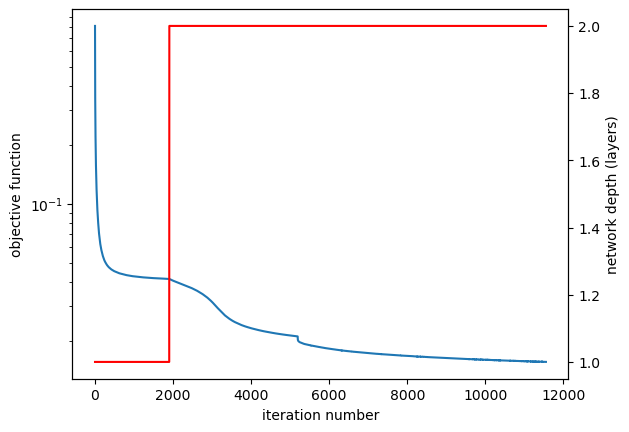

In [95]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.semilogy(np.array(o_recI)[:,0])
ax.set_xlabel("iteration number")
ax.set_ylabel("objective function")
ax1.set_ylabel("network depth (layers)")
ax1.plot(np.array(o_recI)[:,2], color='red')

4


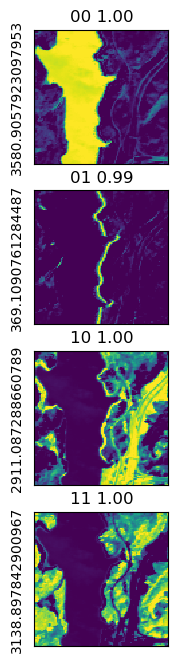

In [96]:
deh3.display_level(2)

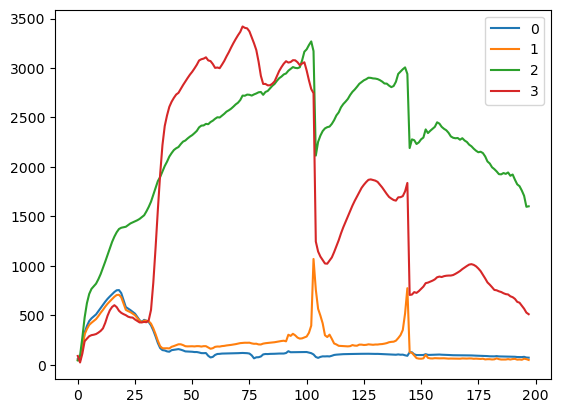

In [99]:
deh2.display_spectra(['00','01','10','11'])

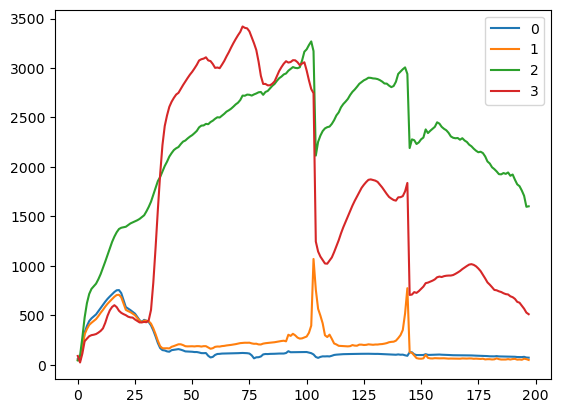

In [131]:
deh2.display_spectra(['00','01','10','11'])

In [ ]:
deh3.grow_network_closed(ji, beta=0.5, tol=1e-5, betab=0.5, tolb=1e-5,
                         obj_record=o_recI, sampling_points=samppts, scaling_factor=16)

In [129]:
deh3.quick_alt_ll(  ji, beta=0.5, tol=1e-8, n_update_points=2000, sampling_points=samppts,
                      obj_record=o_recI)

0.1459857001900673 [0.043030795, 0.014981028]
0.14597684890031815 [0.043030795, 0.014978815]
0.1459815725684166 [0.043030795, 0.014979996]
0.14597656577825546 [0.043030795, 0.014978744]
0.14597271382808685 [0.043030795, 0.014977781]
0.14597956091165543 [0.043030795, 0.014979493]
0.1459825560450554 [0.043030795, 0.014980242]
0.1459750346839428 [0.043030795, 0.014978361]
0.14597676694393158 [0.043030795, 0.014978794]
0.14597934484481812 [0.043030795, 0.014979439]
0.14596862345933914 [0.043030795, 0.0149767585]
0.14596013352274895 [0.043030795, 0.014974636]
0.14596176147460938 [0.043030795, 0.014975043]
0.145964827388525 [0.043030795, 0.0149758095]
0.1459636650979519 [0.043030795, 0.014975519]
0.14596135541796684 [0.043030795, 0.0149749415]
0.1459602490067482 [0.043030795, 0.014974665]
0.14596055448055267 [0.043030795, 0.014974741]
0.14596206322312355 [0.043030795, 0.014975118]
0.14595409855246544 [0.043030795, 0.014973127]
0.14594804868102074 [0.043030795, 0.014971615]
0.1459515057504177

0.14575033262372017 [0.043030795, 0.014922186]
0.14575105905532837 [0.043030795, 0.014922367]
0.14574599266052246 [0.043030795, 0.014921101]
0.1457444429397583 [0.043030795, 0.014920713]
0.1457594819366932 [0.043030795, 0.014924473]
0.14576487615704536 [0.043030795, 0.014925822]
0.14576898515224457 [0.043030795, 0.014926849]
0.14577017351984978 [0.043030795, 0.014927146]
0.14575743675231934 [0.043030795, 0.014923962]
0.14573829993605614 [0.043030795, 0.014919178]
0.14573832228779793 [0.043030795, 0.014919183]
0.14574525877833366 [0.043030795, 0.014920917]
0.14575158432126045 [0.043030795, 0.014922499]
0.14574898406863213 [0.043030795, 0.014921849]
0.14575114101171494 [0.043030795, 0.014922388]
0.14573632553219795 [0.043030795, 0.014918684]
0.14573924615979195 [0.043030795, 0.014919414]
0.14573904126882553 [0.043030795, 0.014919363]
0.14573394507169724 [0.043030795, 0.014918089]
0.1457335501909256 [0.043030795, 0.01491799]
0.14572691917419434 [0.043030795, 0.014916332]
0.145733088254928

0.14555853605270386 [0.043030795, 0.014874237]
0.14555544406175613 [0.043030795, 0.014873464]
0.14555444195866585 [0.043030795, 0.014873213]
0.14555295556783676 [0.043030795, 0.014872842]
0.14555556327104568 [0.043030795, 0.014873493]
0.145547516644001 [0.043030795, 0.014871482]
0.14555619657039642 [0.043030795, 0.014873652]
0.14555099606513977 [0.043030795, 0.014872352]
0.14554468169808388 [0.043030795, 0.014870773]
0.14555472135543823 [0.043030795, 0.014873283]
0.14554933831095695 [0.043030795, 0.014871937]
0.14553596824407578 [0.043030795, 0.014868595]
0.14553473517298698 [0.043030795, 0.014868286]
0.1455347165465355 [0.043030795, 0.014868282]
0.14553604647517204 [0.043030795, 0.014868614]
0.14554502815008163 [0.043030795, 0.01487086]
0.14553633704781532 [0.043030795, 0.014868687]
0.1455330103635788 [0.043030795, 0.014867855]
0.1455414742231369 [0.043030795, 0.014869971]
0.14555056393146515 [0.043030795, 0.014872244]
0.1455250382423401 [0.043030795, 0.014865862]
0.14553044363856316 

0.14535348862409592 [0.043030795, 0.014822975]
0.14535105600953102 [0.043030795, 0.014822367]
0.14535285532474518 [0.043030795, 0.0148228165]
0.145362701267004 [0.043030795, 0.014825278]
0.14536748826503754 [0.043030795, 0.014826475]
0.14535509422421455 [0.043030795, 0.014823376]
0.14534736052155495 [0.043030795, 0.014821443]
0.14534804224967957 [0.043030795, 0.014821613]
0.1453583799302578 [0.043030795, 0.014824198]
0.145339734852314 [0.043030795, 0.014819536]
0.14533783495426178 [0.043030795, 0.014819061]
0.1453375667333603 [0.043030795, 0.014818994]
0.145344790071249 [0.043030795, 0.0148208]
0.14534742385149002 [0.043030795, 0.014821459]
0.14534512162208557 [0.043030795, 0.014820883]
0.1453375443816185 [0.043030795, 0.014818989]
0.14532850310206413 [0.043030795, 0.014816728]
0.14532850310206413 [0.043030795, 0.014816728]


In [179]:
deh3.quick_alt( ji, beta=0.3, tol=1e-8, n_update_points=2000, sampling_points=samppts,
                      obj_record=o_recI, scaling_factor=32)

depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.442245721817017 [0.042998083, 0.0147131905]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.444329261779785 [0.042990655, 0.014715457]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.44916045665741 [0.042972323, 0.014720748]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.441975355148315 [0.042999797, 0.014712873]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.442108392715454 [0.04299877, 0.014713035]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.44805157184601 [0.042977247, 0.014719511]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.440518379211426 [0.043015897, 0.014710947]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.44818615913391 [0.042978533, 0.014719603]
depth of  0
depth of  1
 00
 01
 10
 11
depth of  0
depth of  1
16.443655252456665 [0.04299266, 0.0147147365]
depth of  0
d

KeyboardInterrupt: 

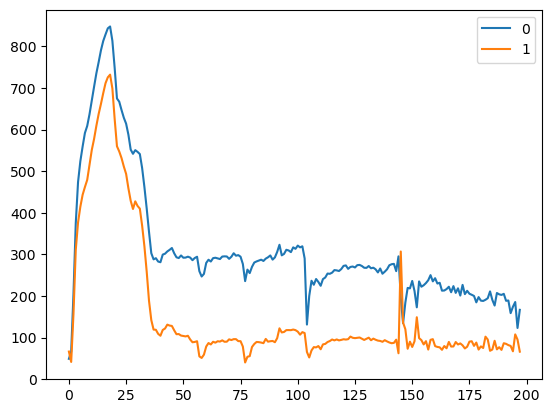

In [191]:
deh4.display_spectra(['11','10'])

4


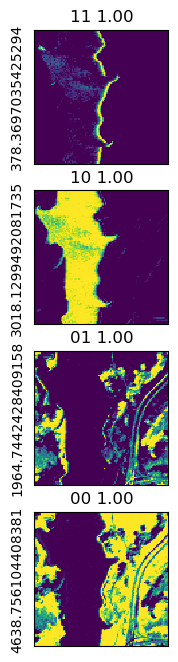

In [207]:
deh4.predict(ji)
deh4.display_level(2)

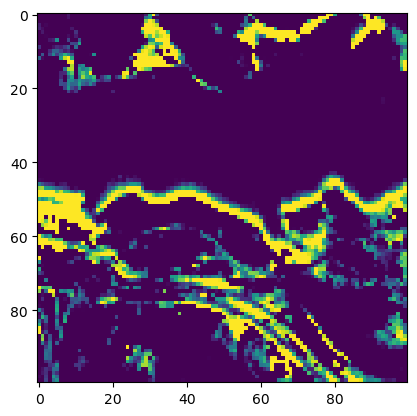

In [136]:
plt.imshow(deh3.nodes['01'].lmda.reshape((100,100)))

In [135]:
deh3.set_lmda()

In [204]:
#with version 0 and tightened constraints, with one loop, switched to spatial and increased min size
# looks like the lower threshold does help to split the water
il.reload(deh)
deh4 = deh.DEH(no_negative_residuals=True)
deh4.splitting_size=1000
deh4.max_depth=2
deh4.max_iter=0
deh4.plot_size = (100,100)
deh4.plot_aspect = 1
deh4.random_init(ji, 16)

In [168]:
deh3.quick_alt_ll(  ji, beta=0.5, tol=1e-8, n_update_points=2000, sampling_points=samppts,
                      obj_record=o_recI)

0.144872285425663 [0.04298843, 0.014723856]
0.1448705680668354 [0.04298843, 0.014723427]
0.14486560225486755 [0.04298843, 0.014722185]
0.14486946165561676 [0.04298843, 0.01472315]
0.14486518129706383 [0.04298843, 0.01472208]
0.14486127346754074 [0.04298843, 0.014721103]
0.1448652520775795 [0.04298843, 0.014722098]
0.14486898481845856 [0.04298843, 0.014723031]
0.14485935121774673 [0.04298843, 0.014720622]
0.14486483111977577 [0.04298843, 0.014721992]
0.14485545456409454 [0.04298843, 0.014719648]
0.1448565274477005 [0.04298843, 0.0147199165]
0.14485235884785652 [0.04298843, 0.014718874]
0.14486143738031387 [0.04298843, 0.014721144]
0.14486145228147507 [0.04298843, 0.014721148]
0.14485663920640945 [0.04298843, 0.014719944]
0.14486262574791908 [0.04298843, 0.014721441]
0.14486638829112053 [0.04298843, 0.014722382]
0.14486286789178848 [0.04298843, 0.014721502]
0.14484961330890656 [0.04298843, 0.014718188]
0.14485009014606476 [0.04298843, 0.014718307]
0.14486605674028397 [0.04298843, 0.01472

KeyboardInterrupt: 

In [205]:
deh4.switch_training(  ji, beta=0.1, tol=1e-6, n_update_points=200, sampling_points=samppts,
                      obj_record=o_recI, scaling_factor=16)

18.240086689591408 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.03512027]
18.239631786942482 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.035118494]
18.23919977247715 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.035116807]
18.238699093461037 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.03511485]
18.23791040480137 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.03511177]
18.237301006913185 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.03510939]
18.237022534012794 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.0351083]
18.236642971634865 [0.0747818, 0.059504874, 0.042022012, 0.037246972, 0.036341023, 0.035255555, 0.03523686, 0.03510682]
18.236223354935646 [0.0747818, 0.05950487

KeyboardInterrupt: 

In [206]:
deh4.trim(2)